In [9]:
import os
from pathlib import Path
import requests
import tarfile
from tqdm import tqdm
import json
import numpy as np
import shutil
import pandas as pd
import librosa
import librosa.display
import sounddevice as sd
sd.default.samplerate = 16000
from IPython.display import Audio
import torch
from torch.utils import data
from torch.autograd import Variable
import torchaudio as ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlp64.st import *

import scipy.fft as spfft
librosa.set_fftlib(spfft)

pd.set_option('display.max_columns', 30)

In [2]:
a = np.ones((2, 3, 2, 2))
m, n_C, n_H, n_W = a.shape

In [3]:
a[0, 0, :] = 1
a[0, 1, :] = 2
a[0, 2, :] = 3
a[1, 1, :] = 42
a[1, 0, :] = 41
a[1, 2, :] = 43

In [4]:
A = torch.from_numpy(a)

In [12]:
A

tensor([[[[ 1.,  1.],
          [ 1.,  1.]],

         [[ 2.,  2.],
          [ 2.,  2.]],

         [[ 3.,  3.],
          [ 3.,  3.]]],


        [[[41., 41.],
          [41., 41.]],

         [[42., 42.],
          [42., 42.]],

         [[43., 43.],
          [43., 43.]]]], dtype=torch.float64)

In [13]:
print(A.shape)
A.sum(1)

torch.Size([2, 3, 2, 2])


tensor([[[  6.,   6.],
         [  6.,   6.]],

        [[126., 126.],
         [126., 126.]]], dtype=torch.float64)

In [5]:
sstyle = '../baselines/target0_brass_acoustic_046-059-075.wav'

In [6]:
style, _ = librosa.load(sstyle, sr=16000)

In [7]:
birds, _ = librosa.load("../baselines/birds.wav", sr=16000)
other, _ = librosa.load("../birdsout.wav", sr=16000)

In [8]:
spec = stft(style, 1024, 128)
other = stft(other, 1024, 128)
birds = stft(birds, 1024, 128)

In [9]:
def ps(x):
    return np.expm1(x) ** 2


def db(x):
    return 20 * np.log10(x)


def rms_contrast(x):
    I = x.mean()
    return np.sqrt(1 / np.prod(x.shape) * np.sum((x - I) ** 2))


def webernorm(x):
    return (x.max() - x.mean()) / x.mean()


def cl(x):
    x = norm(x)
    contrast = (x.max() - x.mean()) / (x.mean())
    return torch.exp(contrast)

def quantile(t: torch.tensor, q: float):
    """
    Return the ``q``-th percentile of the flattened input tensor's data.
    https://gist.github.com/spezold/42a451682422beb42bc43ad0c0967a30

    CAUTION:
     * Needs PyTorch >= 1.1.0, as ``torch.kthvalue()`` is used.
     * Values are not interpolated, which corresponds to
       ``numpy.percentile(..., interpolation="nearest")``.

    :param t: Input tensor.
    :param q: Percentile to compute, which must be between 0 and 100 inclusive.
    :return: Resulting value (scalar).
    """
    # Note that ``kthvalue()`` works one-based, i.e. the first sorted value
    # indeed corresponds to k=1, not k=0! Use float(q) instead of q directly,
    # so that ``round()`` returns an integer, even if q is a np.float32.
    k = 1 + round(float(q) * (t.numel() - 1))
    result = t.view(-1).kthvalue(k).values.item()
    return result

def norm01(x):
    return (x - x.min()) / handle_zeros(x.max() - x.min())

def norm02(x):
    return (x - x.min()) / (x.max() - x.min())


def norm(x):
    return (x - x.mean()) / x.std()


def handle_zeros(x):
    if x == .0:
        return 1.
    else:
        return x

/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


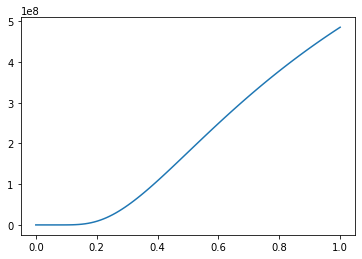

In [68]:
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(20-(1-x)/x))

In [47]:
norm01(torch.from_numpy(spec))

tensor([[1.1392e-05, 1.8218e-03, 4.9313e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6716e-04, 1.9927e-03, 5.0637e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.6985e-06, 1.9164e-03, 5.2604e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.4891e-04, 1.2895e-04, 8.6325e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0631e-04, 1.9203e-04, 1.5419e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0160e-04, 1.5551e-04, 4.9386e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [58]:
print(rms_contrast(norm(spec)))
print(rms_contrast(norm(birds)))
print(rms_contrast(norm(other)))
print(webernorm(spec))
print(webernorm(birds))
print(webernorm(other))
np.log1p(1 - webernorm(birds)/webernorm(birds-0.2))

0.14890516560779515
0.06568254182066638
0.10714253976713901
3.9738765
4.647501
1.7605814


/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log2


nan

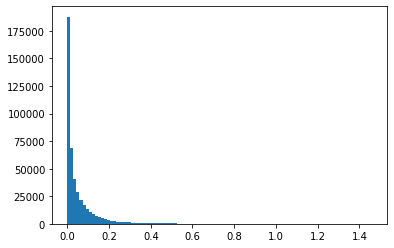

In [45]:
plt.hist(birds.ravel(), bins=100);

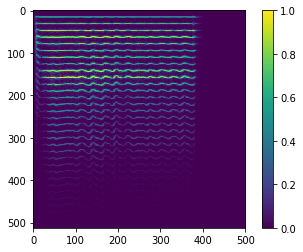

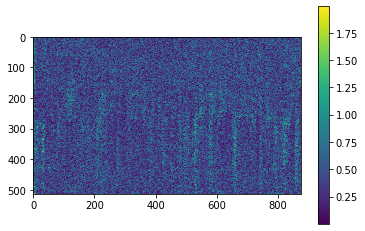

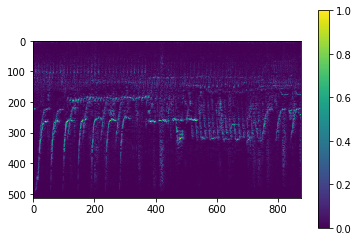

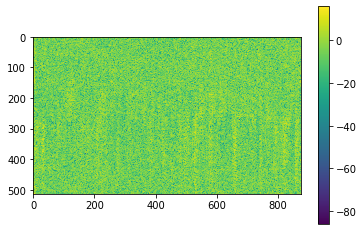

In [57]:
plt.imshow(norm(spec))
plt.colorbar()
plt.figure()
plt.imshow(other)
plt.colorbar()
plt.figure()
plt.imshow(norm(birds))
plt.colorbar()
plt.figure(); plt.imshow(db(np.expm1(other))); plt.colorbar()

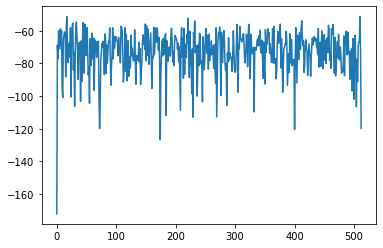

In [12]:
plt.plot(db(ps(other).min(axis=1)))

/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


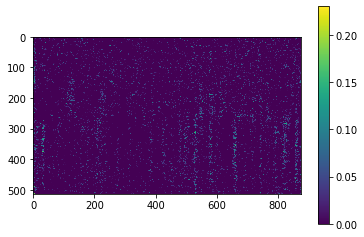

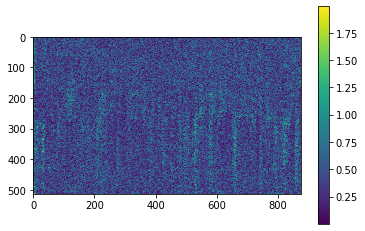

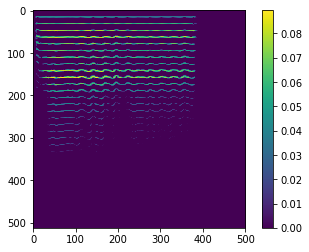

In [13]:
snr = db(np.expm1(other)) / db(np.expm1(other)**2).min(axis=1)[:, None]
snr[snr > 0] = 0
plt.imshow(-snr)
plt.colorbar()
plt.figure()
plt.imshow(other)
plt.colorbar()

plt.figure()
snr = db(np.expm1(spec)) / db(np.expm1(spec + 1e-9)**2).min(axis=1)[:, None]
snr[snr > 0] = 0
plt.imshow(-snr)
plt.colorbar()

In [184]:
def gram(x: torch.Tensor):
    b, c, h, w = x.shape
    F = x.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G

def gram2(x: torch.Tensor):
    c, h, w = x.shape
    F = x
    #F = x.view(c * h, w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G

def gram3(x: torch.Tensor):
    c, b, t = x.shape
    return torch.matmul(x, x.transpose(1, 2))

def gram4(x):
    x = x.transpose(1, 0)
    return torch.bmm(x, x.transpose(1, 2)).transpose(0, 2)

def gram5(A):
    out = torch.zeros(A.shape[0], A.shape[0], A.shape[1])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            for x in range(A.shape[1]):
                out[i, j, x] = A[i, x, :, None].T @ A[j, x, :, None]
    return out

def gram6(x):
    x = x.transpose(2, 1)
    return torch.matmul(x, x.transpose(2, 3)).transpose(1, 3)

In [185]:
b = np.array(range(1, 9)).reshape((2,2,2))
B = torch.from_numpy(np.array(range(1, 9))).view(2, 2, 2).float()

In [171]:
nn.functional.conv_tbc

tensor([[[1., 3.],
         [2., 4.]],

        [[5., 7.],
         [6., 8.]]])

In [162]:
B.transpose(1, 0).transpose(1, 2)

tensor([[[1., 5.],
         [2., 6.]],

        [[3., 7.],
         [4., 8.]]])

In [186]:
gram3(B.transpose(1, 0)).transpose(0, 2)

tensor([[[  5.,  25.],
         [ 17.,  53.]],

        [[ 17.,  53.],
         [ 61., 113.]]])

In [197]:
C = B[None, :, :, :]

In [198]:
torch.nn.functional.conv2d(C, torch.ones(2, 2, 1, 1)).shape

torch.Size([1, 2, 2, 2])

In [199]:
torch.nn.functional.conv1d(B, torch.ones(2, 2, 1))

tensor([[[ 4.,  6.],
         [ 4.,  6.]],

        [[12., 14.],
         [12., 14.]]])

In [139]:
print(torch.nn.functional.conv_tbc(B, torch.ones(1, 2, 2), bias=torch.zeros(2)))
torch.nn.functional.conv1d(B, torch.ones(1, 2, 2))

tensor([[[ 3.,  3.],
         [ 7.,  7.]],

        [[11., 11.],
         [15., 15.]]])


tensor([[[10.]],

        [[26.]]])

In [32]:
a = np.array([[1,2],[3,4]])
print(a, "\n",a.T)
a@a.T

[[1 2]
 [3 4]] 
 [[1 3]
 [2 4]]


array([[ 5, 11],
       [11, 25]])

In [28]:
print(gram5(B))
print(gram3(B))

tensor([[[  5.,  25.],
         [ 17.,  53.]],

        [[ 17.,  53.],
         [ 61., 113.]]])
tensor([[[  5,  11],
         [ 11,  25]],

        [[ 61,  83],
         [ 83, 113]]])


In [189]:
gram4(B)

tensor([[[  5.,  25.],
         [ 17.,  53.]],

        [[ 17.,  53.],
         [ 61., 113.]]])

In [218]:
a = np.ones((3, 3, 4))
a[0, :, 0] = 1
a[0, :, 1] = 2
a[0, :, 2] = 3
a[0, :, 3] = 4
a[0, 1, :] *= 3
a[0, 2, :] *= 4
a[1, :, 0] = 11
a[1, :, 1] = 12
a[1, :, 2] = 13
a[1, :, 3] = 14
a[1, 1, :] *= 2
a[1, 2, :] *= 3
a[2, :, 0] = 21
a[2, :, 1] = 22
a[2, :, 2] = 23
a[2, :, 3] = 24
a[2, 1, :] *= 2
a[2, 2, :] *= 3


A = torch.from_numpy(a)
print(A.shape)
A

torch.Size([3, 3, 4])


tensor([[[ 1.,  2.,  3.,  4.],
         [ 3.,  6.,  9., 12.],
         [ 4.,  8., 12., 16.]],

        [[11., 12., 13., 14.],
         [22., 24., 26., 28.],
         [33., 36., 39., 42.]],

        [[21., 22., 23., 24.],
         [42., 44., 46., 48.],
         [63., 66., 69., 72.]]], dtype=torch.float64)

In [220]:
A.shape

torch.Size([3, 3, 4])

In [224]:
A.transpose(0, 2)[None, :].shape

torch.Size([1, 4, 3, 3])

In [205]:
63**2 + 66*2 + 69**2 + 72**2

14046

In [210]:
%%timeit
gram4(A)

7.93 µs ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [211]:
%%timeit
gram5(A)

555 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [212]:
gram6(A[None, :])

tensor([[[[   30.,   270.,   480.],
          [  130.,   780.,  1560.],
          [  230.,  1380.,  2760.]],

         [[  130.,   780.,  1560.],
          [  630.,  2520.,  5670.],
          [ 1130.,  4520., 10170.]],

         [[  230.,  1380.,  2760.],
          [ 1130.,  4520., 10170.],
          [ 2030.,  8120., 18270.]]]], dtype=torch.float64)

In [215]:
A

tensor([[[ 1.,  2.,  3.,  4.],
         [ 3.,  6.,  9., 12.],
         [ 4.,  8., 12., 16.]],

        [[11., 12., 13., 14.],
         [22., 24., 26., 28.],
         [33., 36., 39., 42.]],

        [[21., 22., 23., 24.],
         [42., 44., 46., 48.],
         [63., 66., 69., 72.]]], dtype=torch.float64)

In [217]:
out = torch.ones(3, 3, 3)

for i in range(A.shape[0]):
    for j in range(A.shape[0]):
        for x in range(A.shape[1]):
            out[i, j, x] = torch.sum(A[i, x] * A[j, x])
print(out)
for i in range(A.shape[0]):
    for j in range(A.shape[0]):
        print(A[i], "\n", A[j])


tensor([[[   30.,   270.,   480.],
         [  130.,   780.,  1560.],
         [  230.,  1380.,  2760.]],

        [[  130.,   780.,  1560.],
         [  630.,  2520.,  5670.],
         [ 1130.,  4520., 10170.]],

        [[  230.,  1380.,  2760.],
         [ 1130.,  4520., 10170.],
         [ 2030.,  8120., 18270.]]])
tensor([[ 1.,  2.,  3.,  4.],
        [ 3.,  6.,  9., 12.],
        [ 4.,  8., 12., 16.]], dtype=torch.float64) 
 tensor([[ 1.,  2.,  3.,  4.],
        [ 3.,  6.,  9., 12.],
        [ 4.,  8., 12., 16.]], dtype=torch.float64)
tensor([[ 1.,  2.,  3.,  4.],
        [ 3.,  6.,  9., 12.],
        [ 4.,  8., 12., 16.]], dtype=torch.float64) 
 tensor([[11., 12., 13., 14.],
        [22., 24., 26., 28.],
        [33., 36., 39., 42.]], dtype=torch.float64)
tensor([[ 1.,  2.,  3.,  4.],
        [ 3.,  6.,  9., 12.],
        [ 4.,  8., 12., 16.]], dtype=torch.float64) 
 tensor([[21., 22., 23., 24.],
        [42., 44., 46., 48.],
        [63., 66., 69., 72.]], dtype=torch.float64)
t

In [241]:
out

tensor([[[  30.,  270.,  480.],
         [ 130.,  780., 1560.]],

        [[ 130.,  780., 1560.],
         [ 630., 2520., 5670.]]])

In [263]:
A

tensor([[[ 1.,  2.,  3.,  4.],
         [ 3.,  6.,  9., 12.],
         [ 4.,  8., 12., 16.]],

        [[11., 12., 13., 14.],
         [22., 24., 26., 28.],
         [33., 36., 39., 42.]]], dtype=torch.float64)

In [300]:
gram4(A.view(2, 4, 3)).view(2, 2, 3)

RuntimeError: shape '[2, 2, 3]' is invalid for input of size 18

In [245]:
A[1].t()

tensor([[11., 22., 33.],
        [12., 24., 36.],
        [13., 26., 39.],
        [14., 28., 42.]], dtype=torch.float64)

In [196]:
t2

(2, 2)

In [242]:
t1 = (0, 0); t2 = (0, 0)
for i1 in range(3):
    for i2 in range(3):
        for j1 in range(3):
            for j2 in range(3):
                t1 = (i1, i2)
                t2 = (j1, j2)
                try:
                    print(torch.bmm(A.transpose(*t1), A.transpose(*t2)))
                    print(torch.bmm(A.transpose(*t1), A.transpose(*t2)).shape)
                    print(t1, t2)
                except:
                    pass

tensor([[[  30.,   90.,  120.],
         [  90.,  270.,  360.],
         [ 120.,  360.,  480.]],

        [[ 630., 1260., 1890.],
         [1260., 2520., 3780.],
         [1890., 3780., 5670.]]], dtype=torch.float64)
torch.Size([2, 3, 3])
(0, 0) (1, 2)
tensor([[[  30.,   90.,  120.],
         [  90.,  270.,  360.],
         [ 120.,  360.,  480.]],

        [[ 630., 1260., 1890.],
         [1260., 2520., 3780.],
         [1890., 3780., 5670.]]], dtype=torch.float64)
torch.Size([2, 3, 3])
(0, 0) (2, 1)
tensor([[[  30.,   90.,  120.],
         [  90.,  270.,  360.],
         [ 120.,  360.,  480.]],

        [[ 630., 1260., 1890.],
         [1260., 2520., 3780.],
         [1890., 3780., 5670.]]], dtype=torch.float64)
torch.Size([2, 3, 3])
(1, 1) (1, 2)
tensor([[[  30.,   90.,  120.],
         [  90.,  270.,  360.],
         [ 120.,  360.,  480.]],

        [[ 630., 1260., 1890.],
         [1260., 2520., 3780.],
         [1890., 3780., 5670.]]], dtype=torch.float64)
torch.Size([2, 3, 3])
(1

In [167]:
gram3(A)

tensor([[[  30.,   90.,  120.],
         [  90.,  270.,  360.],
         [ 120.,  360.,  480.]],

        [[ 630., 1260., 1890.],
         [1260., 2520., 3780.],
         [1890., 3780., 5670.]]], dtype=torch.float64)

tensor([[[ 1.,  2.,  3.,  4.],
         [11., 12., 13., 14.]],

        [[ 3.,  6.,  9., 12.],
         [22., 24., 26., 28.]],

        [[ 4.,  8., 12., 16.],
         [33., 36., 39., 42.]]], dtype=torch.float64)

In [92]:
?torch.dot

Docstring:
dot(input, tensor) -> Tensor

Computes the dot product (inner product) of two tensors.

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.

Example::

    >>> torch.dot(torch.tensor([2, 3]), torch.tensor([2, 1]))
    tensor(7)
Type:      builtin_function_or_method


In [91]:
torch.dot(A, A)

RuntimeError: 1D tensors expected, got 3D, 3D tensors at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:733

In [31]:
x = torch.rand(1, 10, 11)
gram2(x).shape

torch.Size([1, 10, 10])

In [69]:
torch.dot?

Docstring:
dot(input, tensor) -> Tensor

Computes the dot product (inner product) of two tensors.

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.

Example::

    >>> torch.dot(torch.tensor([2, 3]), torch.tensor([2, 1]))
    tensor(7)
Type:      builtin_function_or_method


In [11]:
x, sr = librosa.load("../baselines/keyboard.wav", sr=16000)
Audio(x, rate=sr)

In [3]:
x, sr = librosa.load("../baselines/birds.wav", sr=16000)
Audio(x, rate=sr)

In [38]:
x, sr = librosa.load("../baselines/mallet.wav", sr=16000)
Audio(x, rate=sr)

In [8]:
x, sr = librosa.load("../test.wav", sr=16000)
Audio(x, rate=sr)

In [35]:
x, sr = librosa.load("../out.wav", sr=16000)
Audio(x, rate=sr)